In [1]:
%pylab inline
import imageio
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from warnings import simplefilter


# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
sns.set()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def plotGrayImage(data, title=""):
    plt.imshow(data, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title(title)
    plt.show()

def cropImage(im, size):
    """This function crops the center of the image with the size specified by user"""
    x, y = im.shape
    middleX = round(x / 2)
    middleY = round(y / 2)
    margin = int((size / 2))
    return im[middleX - margin:middleX + margin,middleX - margin:middleX + margin]

def addBorderZeroPaddToImage(im, extraBorderWidth):
    """This function creates a zero padding to the image, the width of the border is related with the parameter 
    extraBorderWidth"""
    return np.pad(im, extraBorderWidth, 'constant', constant_values=0)

def resizeImage(im, size):
    """This normalize the image to the size specified, it simply make the image bigger with zeros and then crop the
    image to the size declared by user"""
    return cropImage(addBorderZeroPaddToImage(im, size),size)

def processToHistVectorImages(x, maxSize, bins=40):
    """This method converts the original image into a single vector, which is the histogram of the image"""
    
    """This line resizes the image adding a zero padding and ajusted the same size to all images to the
    maxSize specified by the user. The process if the same that explained above"""
    vector = resizeImage(x, maxSize).ravel()

    """Now I make a transformation of the data by obtaining the histogram of it, I will be use it instead of the original vector
    The porpuse of this is to emphasize the variation of colors (stains and shapes as pattern in the images) instead
    of both the location of the pixels and their values. In this context, the location of the infected stains is noise. 
    
    I got rid of the zero value because it just an outlier that does not provide information for the algorithm
    """
    return list(np.histogram(vector,bins)[0])[1:]

Populating the interactive namespace from numpy and matplotlib


#### Obtaining data from files
As it can be seen below, the dataframe has two column, the data column and the status column. The first one stored the
data as a list of lists (matrix), where each number is a pixel of the image. The latter is statement whether a cell is
infected or not. Status is 1 when cell is infected and zero when is not. 

In [2]:
df = pd.read_json("malaria_cell_images.json")
df.head(2)

,data,status
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


#### Just to see one cell infected with malaria and a healthy one:    

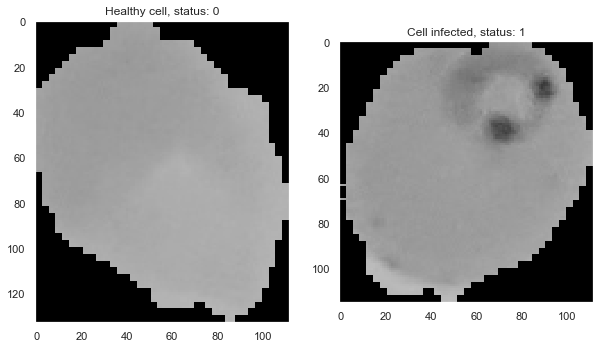

In [3]:
sampleImageInfected = df["data"][0]
sampleImageHealthy = df["data"][len(df["data"]) - 1]
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(sampleImageHealthy, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title("Healthy cell, status: " + str(df["status"][len(df["data"]) -1]))
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(sampleImageInfected, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title("Cell infected, status: " + str(df["status"][0]))
plt.grid(False)
plt.show()

### Since I have notice that images have different dimmensions, I need to make them the same size.
But first I am goint be find the biggest image and make the rest the same size with zero values in the edges (zero padding). 

In [4]:
# Max one side dimension size of a single image in the data set. 
maxSize = np.array([np.array(x).shape for x in df["data"]]).flatten().max()
maxSize # The standard size of all images will be 229x229 pixels

229

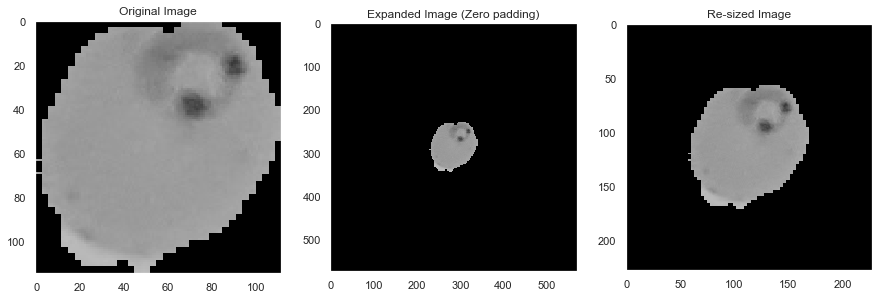

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(sampleImageInfected, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title("Original Image")
plt.grid(False)
plt.subplot(1, 3, 2)
plt.title("Expanded Image (Zero padding)")
plt.imshow(addBorderZeroPaddToImage(sampleImageInfected, maxSize), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.grid(False)
plt.subplot(1, 3, 3)
plt.title("Re-sized Image")
plt.imshow(cropImage(addBorderZeroPaddToImage(sampleImageInfected, maxSize), maxSize), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.grid(False)
plt.show()

### Train-test-validation split

In [6]:
df_train_validation, df_test = train_test_split(df, test_size=0.1, random_state=0)

### Adjusting size of database images and make them a single vector

In [7]:
vectorImages = pd.DataFrame(df_train_validation["data"].apply(lambda x: resizeImage(x, maxSize).ravel()).values.tolist())
# Each column is a pixel of the original image
vectorImages.head(1)

,0,1,2,3,4,5,6,7,8,9,...,51974,51975,51976,51977,51978,51979,51980,51981,51982,51983
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-test-validation split

In [8]:
vectorImages_train, vectorImages_validation, labels_train, labels_validation = train_test_split(vectorImages, df_train_validation["status"], test_size=0.25, random_state=0)

In [9]:
model = LogisticRegression()
model.fit(vectorImages_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
model.score(vectorImages_validation, labels_validation)

0.5416666666666666

Since the accuracy is barely better than a flip a coin estimator, I have to change the strategy to improve the model. 

The current model does such a horrible job because the observable pattern (the one that has to be enclosed or segmented
by the classifier) is in different dimmensions in each sample so the optimization algorithm does not know where to go to truly fit the model and reduce its error. 

In [11]:
histVectorImages = pd.DataFrame(df_train_validation["data"].apply(lambda x: processToHistVectorImages(x, maxSize)).values.tolist())

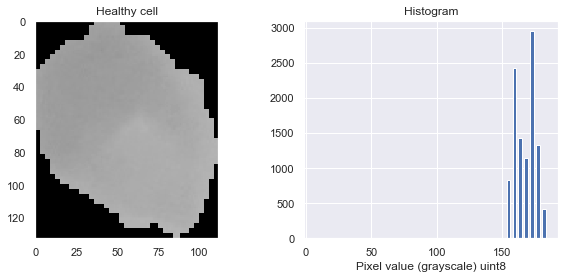

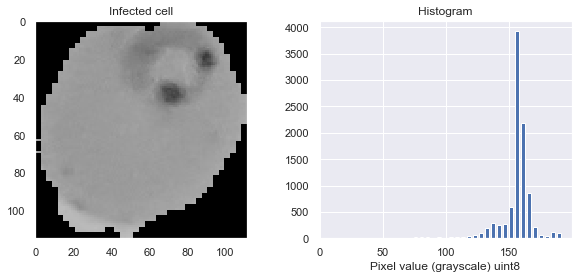

In [12]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(sampleImageHealthy, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title("Healthy cell")
plt.grid(False)
plt.subplot(1, 2, 2)
values = np.histogram(resizeImage(sampleImageHealthy, maxSize).ravel(), bins=40)
plt.bar(list(values[1][2:]), list(values[0][1:]), width=3)
plt.title("Histogram")
plt.xlabel("Pixel value (grayscale) uint8")
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(sampleImageInfected, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.title("Infected cell")
plt.grid(False)
plt.subplot(1, 2, 2)
values = np.histogram(resizeImage(sampleImageInfected, maxSize).ravel(), bins=40)
plt.bar(list(values[1][2:]), list(values[0][1:]), width=3)
plt.title("Histogram")
plt.xlabel("Pixel value (grayscale) uint8")
plt.show()

In [13]:
histVectorImages_train, histVectorImages_validation, labels_train, labels_validation = train_test_split(histVectorImages, df_train_validation["status"], test_size=0.25, random_state=0)

In [14]:
histModel = LogisticRegression(max_iter=200)
histModel.fit(histVectorImages_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
histModel.score(histVectorImages_validation, labels_validation)

0.8690476190476191

#### Testing best model with untouched data:

In [16]:
test = pd.DataFrame(df_test["data"].apply(lambda x: processToHistVectorImages(x, maxSize)).values.tolist())
histModel.score(test,df_test["status"])

0.8933333333333333

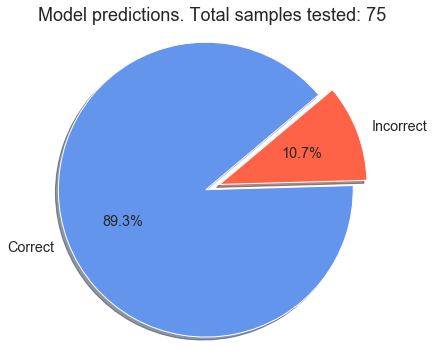

In [17]:
plt.figure(figsize=(6,6))

predict = histModel.predict(test)
real = list(df_test["status"])
correct = []
for index in range(0, len(predict)):
    if predict[index] == real[index]:
        correct.append((index, 1))
    

# Data to plot
labels = 'Correct', 'Incorrect'
sizes = [len(correct), len(predict) - len(correct)]
colors = ['cornflowerblue', 'tomato']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=40, textprops=dict(size="x-large"))
plt.title("Model predictions. Total samples tested: " + str(len(predict)), fontsize=18)
plt.axis('equal')
plt.show()